<a href="https://colab.research.google.com/github/carlomigs/tensortrade/blob/master/examples/migs_TensorTrade_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import warnings
import numpy

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))

In [0]:
!git clone https://github.com/notadamking/tensortrade.git

In [0]:
!pip install -e /content/tensortrade

In [0]:
%cd tensortrade
import os
print(os.getcwd())
%ls

In [7]:
!pip install -e .[tf,tensorforce,baselines,ccxt,fbm] -U

Obtaining file:///content/tensortrade
  Found existing installation: tensortrade 0.0.1a18
    Can't uninstall 'tensortrade'. No files were found to uninstall.
  Running setup.py develop for tensortrade


In [8]:
!pip install talib-binary

     |████████████████████████████████| 2.4MB 2.7MB/s 


In [10]:
#%ls /content/RLTrader/data/input
%ls /content/tensortrade/examples/data/

Coinbase_BTCUSD_1h.csv  Coinbase_BTCUSD_d.csv


Simulated exchanges, on the other hand, are implementations of `InstrumentExchange` backed by simulated pricing data and trade execution. For example, `FBMExchange` is a simulated exchange, which generates pricing and volume data using fractional brownian motion (FBM). Since its price is simulated, the trades it executes must be simulated as well. The exchange uses a simple slippage model to simulate price and volume slippage on trades, though like almost everything in TensorTrade, this slippage model can easily be swapped out for something more complex.

Though the `FBMExchange` generates fake price and volume data using a stochastic model, it is simply an implementation of `SimulatedExchange`. Under the hood, `SimulatedExchange` only requires a `data_frame` of price history to generate its simulations. This data_frame can either be provided by a coded implementation such as `FBMExchange`, or at runtime such as in the following example.

In [11]:
import numpy
import pandas as pd
from tensortrade.exchanges.simulated import SimulatedExchange

df = pd.read_csv('/content/tensortrade/examples/data/Coinbase_BTCUSD_1h.csv', skiprows=1)
#df = pd.read_csv('/content/RLTrader/data/input/coinbase-1h-btc-usd.csv')
exchange = SimulatedExchange(data_frame=df, base_instrument='USD', should_pretransform_obs=True)

exchange.data_frame

,open,high,low,close,volume
0,8051.00,8056.83,8021.23,8035.88,492394.56
1,7975.89,8070.00,7975.89,8051.00,2971610.86
2,7964.62,7987.82,7964.61,7975.89,970521.83
3,7984.02,7993.97,7958.29,7964.62,1692336.84
4,7941.71,7986.99,7937.01,7984.02,774064.91
5,7970.19,7973.23,7937.50,7941.71,1177321.50
6,7986.62,7988.54,7965.61,7970.19,805106.70
7,7960.00,7989.62,7959.74,7986.62,743583.37
8,7966.43,7977.48,7959.74,7960.00,1325771.25
9,7993.54,7995.81,7957.55,7966.43,1584534.00


In [12]:
#df.head()
df.dtypes

date           object
symbol         object
open          float64
high          float64
low           float64
close         float64
volume_btc    float64
volume        float64
dtype: object

## Feature Pipelines

Feature pipelines are meant for transforming observations from the environment into meaningful features for an agent to learn from. If a pipeline has been added to a particular exchange, then observations will be passed through the `FeaturePipeline` before being output to the environment. For example, a feature pipeline could normalize all price values, make a time series stationary, add a moving average column, and remove an unnecessary column, all before the observation is returned to the agent.

Feature pipelines can be initialized with an arbitrary number of comma-separated transformers. Each `FeatureTransformer` needs to be initialized with the set of columns to transform, or if nothing is passed, all input columns will be transformed.

Each feature transformer has a transform method, which will transform a single observation (a `pandas.DataFrame`) from a larger data set, keeping any necessary state in memory to transform the next frame. For this reason, it is often necessary to reset the `FeatureTransformer` periodically. This is done automatically each time the parent `FeaturePipeline` or `InstrumentExchange` is reset.

Let's create an example pipeline and add it to our existing exchange.

In [13]:
from tensortrade.features import FeaturePipeline
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features.stationarity import FractionalDifference

normalize_price = MinMaxNormalizer(["open", "high", "low", "close"])
difference_all = FractionalDifference(difference_order=0.6)

feature_pipeline = FeaturePipeline(steps=[normalize_price, difference_all])

exchange.feature_pipeline = feature_pipeline

exchange.data_frame

/content/tensortrade/tensortrade/features/scalers/min_max_normalizer.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = normalized_column
/content/tensortrade/tensortrade/features/stationarity/fractional_difference.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = diffed_series.fillna(method='bfill')


,open,high,low,close,volume
0,0.001349,0.001319,0.001323,0.001295,3.443566e+05
1,0.001349,0.001319,0.001323,0.001295,3.443566e+05
2,0.001349,0.001319,0.001323,0.001295,3.443566e+05
3,0.001349,0.001319,0.001323,0.001295,3.443566e+05
4,0.001349,0.001319,0.001323,0.001295,3.443566e+05
5,0.001349,0.001319,0.001323,0.001295,3.443566e+05
6,0.001220,0.001211,0.001221,0.001214,-1.976999e+05
7,0.001079,0.001102,0.001097,0.001116,-5.929822e+04
8,0.001017,0.001006,0.001016,0.000996,5.926411e+05
9,0.000974,0.000964,0.000945,0.000948,5.216977e+05


_This feature pipeline normalizes the price values between 0 and 1, before making the entire time series stationary by fractionally differencing consecutive values._

## Action Strategies

Action strategies define the action space of the environment and convert an agent's actions into executable trades. For example, if we were using a discrete action space of 3 actions (0 = `hold`, 1 = `buy 100%`, 2 = `sell 100%`), our learning agent does not need to know that returning an action of 1 is equivalent to buying an instrument. Rather, our agent needs to know the reward for returning an action of 1 in specific circumstances, and can leave the implementation details of converting actions to trades to the `ActionStrategy`.

Each action strategy has a get_trade method, which will transform the agent's specified action into an executable `Trade`. It is often necessary to store additional state within the strategy, for example to keep track of the currently traded position. This state should be reset each time the action strategy's reset method is called, which is done automatically when the parent `TradingEnvironment` is reset.

In [0]:
from tensortrade.actions import DiscreteActionStrategy

action_strategy = DiscreteActionStrategy(n_actions=20, instrument_symbol='BTC')

_This discrete action strategy uses 20 discrete actions, which equates to 4 discrete amounts for each of the 5 trade types (market buy/sell, limit buy/sell, and hold). E.g. [0,5,10,15]=hold, 1=market buy 25%, 2=market sell 25%, 3=limit buy 25%, 4=limit sell 25%, 6=market buy 50%, 7=market sell 50%, etc…_

## Reward Strategies

Reward strategies receive the trade taken at each time step and return a float, corresponding to the benefit of that specific action. For example, if the action taken this step was a sell that resulted in positive profits, our `RewardStrategy` could return a positive number to encourage more trades like this. On the other hand, if the action was a sell that resulted in a loss, the strategy could return a negative reward to teach the agent not to make similar actions in the future.

A version of this example algorithm is implemented in `SimpleProfitStrategy`, however more complex strategies can obviously be used instead.

Each reward strategy has a get_reward method, which takes in the trade executed at each time step and returns a float corresponding to the value of that action. As with action strategies, it is often necessary to store additional state within a reward strategy for various reasons. This state should be reset each time the reward strategy's reset method is called, which is done automatically when the parent `TradingEnvironment` is reset.

In [0]:
from tensortrade.rewards import SimpleProfitStrategy

reward_strategy = SimpleProfitStrategy()

## Trading Strategy

A `TradingStrategy` consists of a learning agent and one or more trading environments to tune, train, and evaluate on. If only one environment is provided, it will be used for tuning, training, and evaluating. Otherwise, a separate environment may be provided at each step.

_Don't worry if you don't understand the strategy initialization just yet, it will be explained in more detail later._

# Putting it All Together

Now that we know about each component that makes up a `TradingStrategy`, let's build and evaluate one.

For a quick recap, a `TradingStrategy` is made up of a `TradingEnvironment` and a learning agent. A `TradingEnvironment` is a gym environment that takes an `InstrumentExchange`, an `ActionStrategy`, a `RewardStrategy`, and an optional `FeaturePipeline`, and returns observations and rewards that the learning agent can be trained and evaluated on.

## Creating an Environment

The first step is to create a `TradingEnvironment` using the components outlined above.

In [0]:
from tensortrade.environments import TradingEnvironment

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy)

Simple enough, now `environment` is a `gym` environment that can be used by any compatible trading strategy or learning agent.

## Defining the Agent

Now that the environment is set up, it’s time to create our learning agent. Again, we will be using Stable Baselines for this, but feel free to drop in any other reinforcement learning agent here.

Since we are using `StableBaselinesTradingStrategy`, all we need to do is provide a model type and a policy type for the underlying neural network to be trained. For this example, we will be using a simple proximal policy optimization (PPO) model and a layer-normalized LSTM policy network.

For more examples of model and policy specifications, see the [Stable Baselines Documentation](http://stable-baselines.readthedocs.io/en/master/).

In [0]:
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines import PPO2

model = PPO2
policy = MlpLnLstmPolicy
params = { "learning_rate": 1e-5, 'nminibatches': 1 }

## Training a Strategy

Creating our trading strategy is as simple as plugging in our agent and the environment.

In [0]:
from tensortrade.strategies import StableBaselinesTradingStrategy

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

Then to train the strategy (i.e. train the agent on the current environment), all we need to do is call `strategy.run()` with the total number of steps or episodes you’d like to run.

In [19]:
performance = strategy.run(steps=10000)

Finished running strategy.
Total episodes: 0 (10000 timesteps).
Average reward: -0.342161492029289.


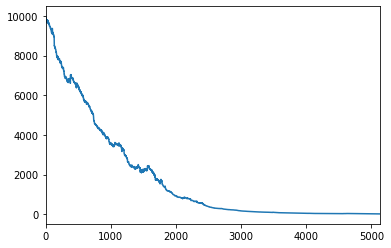

In [20]:
%matplotlib inline

performance.net_worth.plot()

If this feedback loop is a bit slow for you, you can pass a callback function to `run`, which will be called at the end of each episode. The callback function will pass in a `data_frame` containing the agent's performance that episode, and expects a `bool` in return. If `True`, the agent will continue training, otherwise, the agent will stop and return its overall performance.

## Saving and Restoring

All trading strategies are capable of saving their agent to a file, for later restoring. The environment is not saved, as it does not have state that we care about preserving. To save our `TensorflowTradingStrategy` to a file, we just need to provide the path of the file to our strategy.

In [25]:
print(os.getcwd())
%ls

/content/tensortrade
CODE_OF_CONDUCT.md  examples/    ppo_btc_1h.zip    setup.py
CONTRIBUTING.md     LICENSE      README.md         tensortrade/
Dockerfile          Makefile     requirements.txt  tensortrade.egg-info/
docs/               MANIFEST.in  setup.cfg         tests/


In [0]:
strategy.save_agent(path="ppo_btc_1h")

_This specific strategy saves multiple files, including a directory of models to the path provided._

To restore the agent from the file, we first need to instantiate our strategy, before calling restore_agent.

In [0]:
new_strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

new_strategy.restore_agent(path="ppo_btc_1h")

Our strategy is now restored back to its previous state, and ready to be used again. Let's see how it does.

## Tuning Your Strategy

Sometimes a trading strategy will require tuning a set of hyper-parameters, or features, on an environment to achieve maximum performance. In this case, each `TradingStrategy` provides an optionally implementable tune method.

Tuning a model is similar to training a model, however in addition to adjusting and saving the weights and biases of the best performing model, the strategy also adjusts and persists the hyper-parameters that produced that model. 

In [27]:
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import FBMExchange

exchange = FBMExchange(timeframe='1h', base_instrument='BTC', feature_pipeline=feature_pipeline)
environment = TradingEnvironment(exchange=exchange, 
                                 action_strategy=action_strategy, 
                                 reward_strategy=reward_strategy) 
new_strategy.environment = environment 
tuned_performance = new_strategy.tune(episodes=10)

/content/tensortrade/tensortrade/features/scalers/min_max_normalizer.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = normalized_column
/content/tensortrade/tensortrade/features/stationarity/fractional_difference.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = diffed_series.fillna(method='bfill')


NotImplementedError: ignored

In this case, the agent will be trained for 10 episodes, with a different set of hyper-parameters each episode. The best set will be saved within the strategy, and used any time strategy.run() is called thereafter.

## Strategy Evaluation

Now that we've tuned and trained our agent, it's time to see how well it performs. To evaluate our strategy's performance on unseen data, we will need to run it on a new environment backed by such data.

In [29]:
import pandas as pd
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import SimulatedExchange

df = pd.read_csv('/content/tensortrade/examples/data/Coinbase_BTCUSD_d.csv', skiprows=1)
exchange = SimulatedExchange(data_frame=df,
                             feature_pipeline=feature_pipeline,
                             base_instrument='USD',
                             should_pretransform_obs=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy)

new_strategy.environment = environment

test_performance = new_strategy.run(steps=2000)

/content/tensortrade/tensortrade/features/scalers/min_max_normalizer.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = normalized_column
/content/tensortrade/tensortrade/features/stationarity/fractional_difference.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = diffed_series.fillna(method='bfill')


Finished running strategy.
Total episodes: 1 (2000 timesteps).
Average reward: -0.4893612746923733.


In [30]:
df.head()

,date,symbol,open,high,low,close,volume_btc,volume
0,2019-10-17,BTCUSD,7993.54,8070.00,7937.01,8034.32,1570.08,12537245.82
1,2019-10-16,BTCUSD,8162.44,8171.59,7908.86,7993.54,8123.72,65132771.81
2,2019-10-15,BTCUSD,8355.00,8420.00,8085.65,8162.44,7919.56,65109952.98
3,2019-10-14,BTCUSD,8282.97,8409.00,8215.66,8355.00,4401.82,36575829.05
4,2019-10-13,BTCUSD,8309.03,8469.02,8146.47,8282.97,5459.53,45492326.33


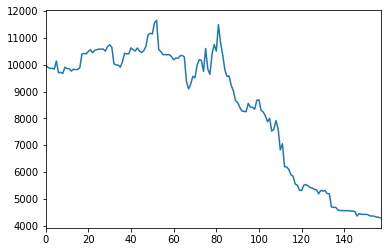

In [31]:
%matplotlib inline

test_performance.net_worth.plot()

When complete, strategy.run returns a `Pandas.data_frame` of the agent's performance, including the net worth and balance of the agent at each time step.

## Live Trading

Once you've built a profitable trading strategy, trained an agent to trade it properly, and ensured its "generalize-ability" to new data sets, all there is left to do is profit. Using a live exchange such as `CCXTExchange`, you can plug your strategy in and let it run!

While the gambler in you may enjoy starting a strategy and letting it run without bounds, the more risk averse of you can use a `trade_callback`, which will be called each time the strategy makes a trade. This callback function, similar to the episode callback, will pass in a data frame containing the agent's overall performance, and expects a `bool` in return. If `True`, the agent will continue trading, otherwise, the agent will stop and return its performance over the session.

In [28]:
import ccxt
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.live import CCXTExchange

binance = ccxt.binance({
    'apiKey': 'HfPX38sJ2aKewYDUJx6TaWrDhuT7rq426elO5Gbc55Dvg4klASEfm0aqcdl4Mpz6',
    'secret': 'aGdMMaaol3GkyzDcrSEoc4aFlWG78qCxnGl3o22ub24u2scrZRcsIe2qn0kI82GQ',
    'enableRateLimit': True,
})

exchange = CCXTExchange(exchange=binance,
                        base_instrument='BNB',
                        observation_type='ohlcv',
                        timeframe='1h')

btcusd_actions = DiscreteActionStrategy(n_actions=20, instrument_symbol='BNB/BTC')

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_strategy=btcusd_actions,
                                 reward_strategy=reward_strategy)

strategy.environment = environment

live_performance = strategy.run(steps=1)

InvalidOrder: ignored

In [0]:
live_performance

{}

_Passing `steps=0` instructs the strategy to run until otherwise stopped._